<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#Reading-and-parsing-data" data-toc-modified-id="Reading-and-parsing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Reading and parsing data</a></span><ul class="toc-item"><li><span><a href="#US-cohort-data" data-toc-modified-id="US-cohort-data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>US cohort data</a></span></li><li><span><a href="#Belgian-cohort" data-toc-modified-id="Belgian-cohort-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Belgian cohort</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Statistics-and-visualisations" data-toc-modified-id="Statistics-and-visualisations-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Statistics and visualisations</a></span><ul class="toc-item"><li><span><a href="#CMV-associated-TCRs-and-unique-TCRs" data-toc-modified-id="CMV-associated-TCRs-and-unique-TCRs-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>CMV associated TCRs and unique TCRs</a></span></li><li><span><a href="#CMV-IgG-values-and-binary-(sero)status" data-toc-modified-id="CMV-IgG-values-and-binary-(sero)status-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>CMV IgG values and binary (sero)status</a></span></li></ul></li><li><span><a href="#Show-training-and-testing-data" data-toc-modified-id="Show-training-and-testing-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Show training and testing data</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Check-performance-on-training-data-(=-US-cohort)" data-toc-modified-id="Check-performance-on-training-data-(=-US-cohort)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Check performance on training data (= US cohort)</a></span></li><li><span><a href="#Check-performance-on-testing-data-(=-Belgian-cohort)" data-toc-modified-id="Check-performance-on-testing-data-(=-Belgian-cohort)-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Check performance on testing data (= Belgian cohort)</a></span></li><li><span><a href="#Bootstrap-AUC-values" data-toc-modified-id="Bootstrap-AUC-values-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Bootstrap AUC values</a></span></li></ul></li></ul></div>

# Introduction

Pathogens of past and current infections have been identified directly by means of PCR or indirectly by measuring a specific immune response (e.g. antibody titration). Using a novel approach, Emerson and colleagues showed that the cytomegalovirus serostatus can also be accurately determined by using a T cell receptor repertoire data mining approach. In this study, we have sequenced the CD4+ memory T cell receptor repertoire of a Belgian cohort with known cytomegalovirus serostatus. A Random Forest classifier was trained on the CMV specific T cell receptor repertoire signature and used to classify individuals in the Belgian cohort. This study shows that the novel approach can be reliably replicated with an equivalent performance as that reported by Emerson and colleagues. Additionally, it provides evidence that the T cell receptor repertoire signature is to a large extent preserved in the CD4+ memory repertoire. 

\* Emerson, R. O. et al. Immunosequencing identifies signatures of cytomegalovirus exposure history and HLA-mediated effects on the T cell repertoire. Nat. Genet. 1–10 (2017). doi:10.1038/ng.3822

# Dependencies

- Matplotlib
- Numpy
- Pandas
- Seaborn
- Sklearn
- Statsmodels


- Custom module: TCR_class

In [1]:
import math
import multiprocessing as mp
import sys

from collections import Counter
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.metrics

from numpy.random import choice
from scipy import stats
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import LeaveOneOut
from statsmodels.stats.multitest import fdrcorrection

import TCR_class as TCRC

sns.set_style('ticks')

# Reading and parsing data

## US cohort data
In the paper by Emerson et al. (Nature Genetics, 2017), a T cell receptor repertoire based signature specific for the cytomegalovirus serostatus is identified. The specific T cell receptors are enumerated in `original_data/ng.3822-S3.xlsx` and was originally obtained from [Supplementary Table 2](https://images.nature.com/original/nature-assets/ng/journal/v49/n5/extref/ng.3822-S3.xlsx).

In [2]:
# path to file
cmv_tcr_path = '../original_data/ng.3822-S3.xlsx'
# read in data as dataframe
cmv_tcrs = pd.read_excel(cmv_tcr_path)
# parse V gene, CDR3 and J gene columns into a single TCR column
cmv_tcrs['TCR'] = cmv_tcrs[['V gene', 'CDR3', 'J gene']].apply(lambda x: '/'.join(x), axis=1)

Read in TCR repertoire features from the Emerson data (= training data). 

Data consist of:
1. Sample name (sample)
2. CMV serostatus (status)
3. presence/absence for each CMV associated TCR
4. number of unique TCRs sequenced (uniques)
5. total number of CMV associated TCRs (TCR_sum)

for all individuals in the cohort.

In [3]:
# path to file
cmv_feature_path = "../original_data/featureDetect.1e-4.CMV.sampleFeatures.tsv"
# read in data as dataframe
data = pd.read_csv(cmv_feature_path, sep='\t')
# parse data tcr column names
data.rename(columns={x: x.replace('|', '/') for x in data.columns.values if x not in 
                      ['sample', 'status', 'uniques']}, inplace=True)
# count how many CMV associated TCRs are present in each individual
data['TCR_sum'] = data[[x for x in data.columns.values if x not in 
                                ['sample', 'status', 'uniques']]].sum(axis=1)

# show part of dataframe
data[['sample', 'status', 'uniques', 'TCR_sum', 
      'TCRBV02-01*01/CASGRDTYEQYF/TCRBJ02-07*01', 
      'TCRBV02-01*01/CASRDWDYTDTQYF/TCRBJ02-03*01', 
      'TCRBV02-01*01/CASRGQGAGELFF/TCRBJ02-02*01']]
    # ... and so on (only three example TCRs shown)

,sample,status,uniques,TCR_sum,TCRBV02-01*01/CASGRDTYEQYF/TCRBJ02-07*01,TCRBV02-01*01/CASRDWDYTDTQYF/TCRBJ02-03*01,TCRBV02-01*01/CASRGQGAGELFF/TCRBJ02-02*01
0,HIP00110,0,101489,2,0,0,0
1,HIP00169,0,94723,1,0,0,0
2,HIP00594,1,156862,14,0,0,0
3,HIP00602,0,191874,4,0,0,0
4,HIP00614,0,99400,1,0,0,0
5,HIP00640,0,199581,1,0,0,0
6,HIP00707,1,168865,7,0,0,0
7,HIP00710,0,71665,1,0,0,0
8,HIP00715,0,282151,0,0,0,0
9,HIP00728,0,90496,0,0,0,0


## Belgian cohort

A cohort consisting of 33 Belgian individuals with known CMV serostatus had their CD4+ memory TCRbeta repertoires sequenced.

Read in CMV serostatus of Belgian individuals

In [4]:
# path to file
CMV_ELISA_path = "../original_data/CMV_ELISA.txt"
# read in data as dataframe
cmv_data = pd.read_csv(CMV_ELISA_path, '\t')

Read in TCR repertoire data of Belgian individuals. Data is saved as TCR repertoire objects (see TCR_class module).

In [5]:
# directory with TCRb repertoire data files
tcrb_seq_dir = "../original_data/belgian_cohort_tcrs"

# find TCRb rep data files to read in
data_files = glob(tcrb_seq_dir+'/*.tsv')

# read in TCRb rep data for each volunteer
reps = {}
for file in data_files:
    file = file.replace('\\', '/')
    print('Reading in {}'.format(file))
    tag = '_'.join(file.split('/')[-1].replace('.tsv', '').split('_')[:3])
    # only keep productive TCR sequences (= remove unexpressed, out-of-frame sequences)
    reps[tag] = TCRC.read_immuneaccess_data(file, version='v2').make_productive_repertoire()

Reading in ../original_data/belgian_cohort_tcrs/H10_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H11_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H13_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H14_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H17_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H18_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H19_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H20_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H21_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H22_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H23_B0_a.tsv
Reading in ../original_data/belgian_cohort_tcrs/H23_B0_b.tsv
Reading in ../original_data/belgian_cohort_tcrs/H24_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H25_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H26_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H28_B0.tsv
Reading in ../original_data/belgian_cohort_tcrs/H29_

Check if CMV IgG ELISA data is available for all volunteers for which we have TCRb sequences

In [6]:
# list of ids for which we have both CMV IgG values and TCR repertoires
common_ids = []

# volunteer ids for which we have repertoires
ids = sorted(set([tag.split('_')[0] for tag in reps.keys()]))

# check for volunteers with TCR repertoire data if they have CMV IgG values available
for tcr_id in ids:
    if cmv_data['Person'].str.contains(tcr_id).any() != True:
        print(tcr_id+': CMV data not present')
    else:
        common_ids.append(tcr_id)

In [7]:
new_reps = {}
for name, rep in reps.items():
    if name.endswith('a'):
        rep_A = reps[name]
        rep_B = reps[name.replace('a', 'b')]
        rep = rep_A + rep_B
        new_reps[name.replace('_a', '')] = rep
        print(name, name.replace('a', 'b'), name.replace('_a', ''))
    elif name.endswith('b'):
        continue
    else:
        new_reps[name] = rep
        
reps = new_reps

H23_B0_a H23_B0_b H23_B0
H8_B0_a H8_B0_b H8_B0


# Data analysis

## Statistics and visualisations

Determine for each volunteer in the Belgian cohort:

1. How many CMV associated TCRs are present in their repertoire (TCR_sum)
2. How many unique TCRs are present in their repertoire (unique)
3. CMV IgG values and associated binary class (seropositive/ -negative)

### CMV associated TCRs and unique TCRs

In [8]:
# dict to hold feature data
volunteer_data = {'TCR_sum': [], 'uniques': [], 'Person': [], 'id': []}

# for each volunteer and its repertoire
for name, rep in reps.items():
    TCR_sum = 0
    # count how often each TCR occurs in the volunteer's repertoire
    counts = Counter([str(tcr) for tcr in rep.TCRs])
    # for each TCR in the known CMV associated TCRs:
    for tcr in cmv_tcrs['TCR']:
        # check if that TCR is present in the volunteer's repertoire
        if tcr in counts.keys():
            # add binary presence/absence indicator to feature data for each CMV associated TCR
            volunteer_data.setdefault(tcr, []).append(1)
            # if TCR is present, increase count of CMV associated TCRs found
            TCR_sum += 1
        else:
            volunteer_data.setdefault(tcr, []).append(0)
    # total number of TCRs found in that volunteer's repertoire
    uniques = len(set(rep.TCRs))
    volunteer_data['uniques'].append(uniques)
    # total number of CMV associated TCRs found in that volunteer's repertoire
    volunteer_data['TCR_sum'].append(TCR_sum)
    volunteer_data['Person'].append(name.split('_')[0])
    volunteer_data['id'].append(name)
volunteer_frame = pd.DataFrame(volunteer_data)

Check which CMV associated TCRs are found in the Belgian volunteers and visualise using a heatmap (blue = TCR absent; red = TCR present).

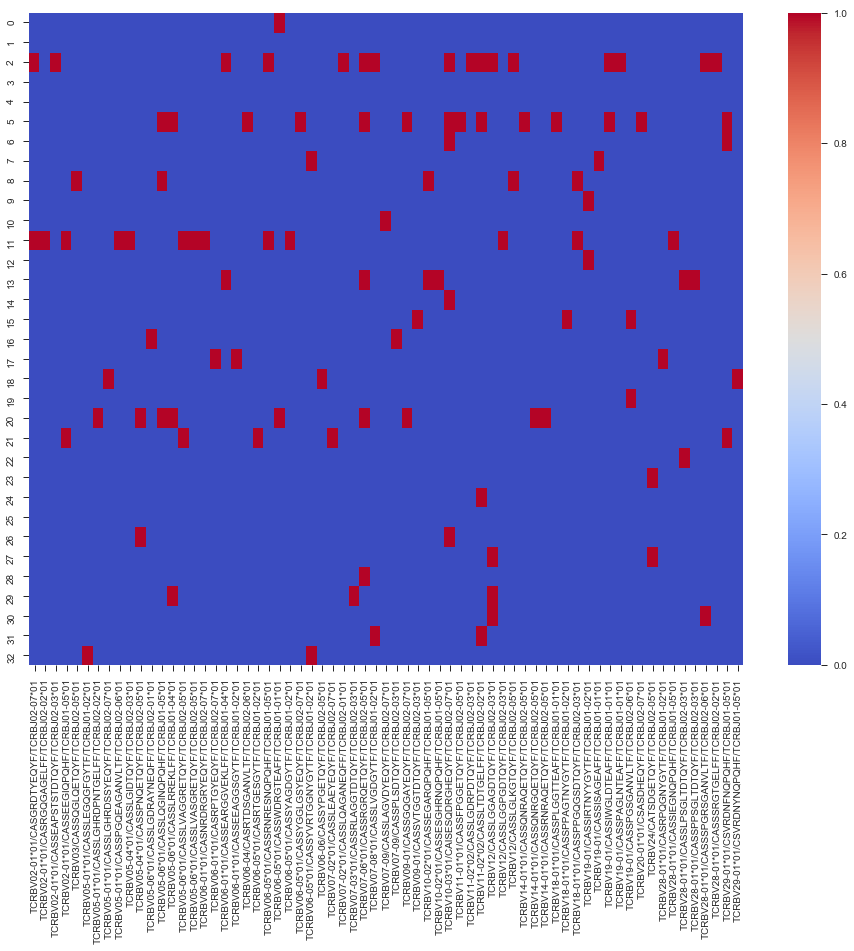

In [9]:
# get names of columns with tcr data
cmv_tcr_cols = [col for col in volunteer_frame.columns if col not in ['TCR_sum', 'uniques', 'Person', 'id']]
# select columns with tcr data (if that tcr is present in at least one individual)
tcr_occurrence_df = volunteer_frame[[col for col in cmv_tcr_cols if volunteer_frame[col].sum() > 0]]

# heatmap of presence/absence
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(tcr_occurrence_df, cmap='coolwarm')
plt.show()

### CMV IgG values and binary (sero)status

In [10]:
# assemble volunteer's CMV serostatus and TCRb repertoire statistics into a single dataframe
volunteer_features = pd.merge(volunteer_frame[['TCR_sum', 'uniques', 'Person']], 
                              cmv_data[['CMV IgG', 'Person']], on='Person')
# convert CMV IgG values to binary class
volunteer_features['CMV serostatus'] = volunteer_features['CMV IgG'].apply(lambda x: 'Positive' 
                                                                       if x > 1 else 'Negative')

# report how many persons we have in each class
num_pos_vol = sum(volunteer_features['CMV serostatus']=='Negative')
num_neg_vol = sum(volunteer_features['CMV serostatus']=='Positive')
print('Assembled CMV serostatus and TCRb repertoire data for:\n{} CMV seropositive individuals\n{} CMV seronegative individuals'.format(
        num_pos_vol, num_neg_vol))

Assembled CMV serostatus and TCRb repertoire data for:
24 CMV seropositive individuals
9 CMV seronegative individuals


Plot distribution of CMV IgG values

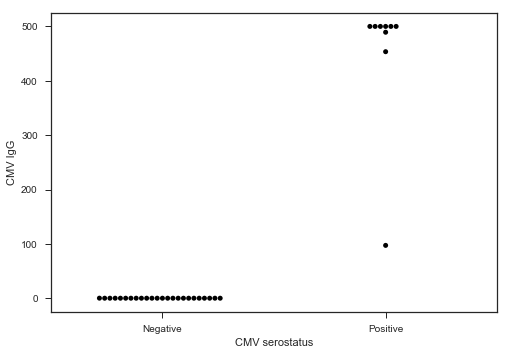

In [11]:
sns.swarmplot(x='CMV serostatus', y='CMV IgG', data=volunteer_features, color='black')
plt.show()

## Show training and testing data

Plot training data (from Emerson et al.) and test data (from volunteers) with labels colored according to CMV status.

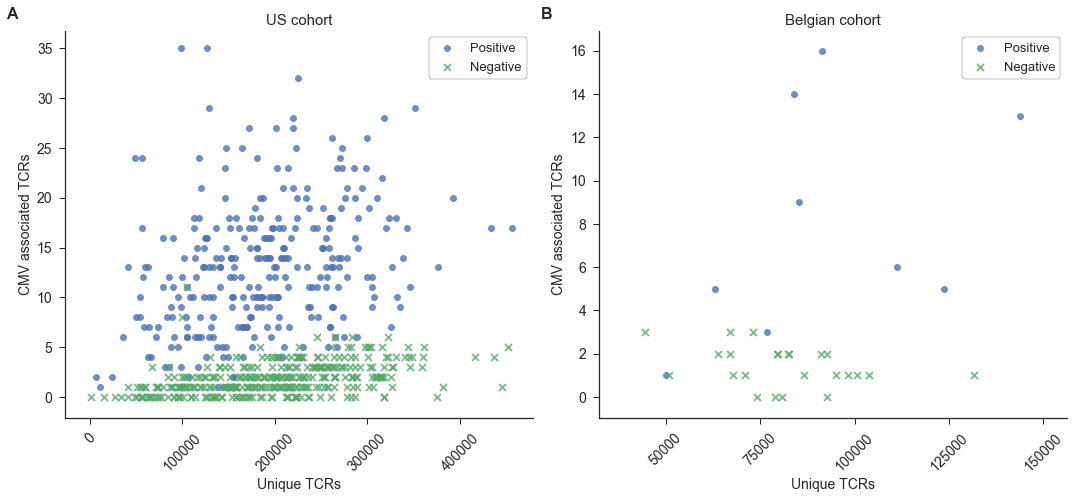

In [12]:
def format_tick_labels(x, pos):
    # formatter function takes tick label and tick position
    # formats tick label to use a ',' as thousand separator
    s = '{:0,d}'.format(int(x))
    return s

y_format = tkr.FuncFormatter(format_tick_labels)  # make formatter

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

data_pos = data[data['status']==1]
data_neg = data[data['status']==0]
sns.regplot(data=data_pos, x='uniques', y='TCR_sum', fit_reg=False, ax=ax1, label='Positive', marker='o')
sns.regplot(data=data_neg, x='uniques', y='TCR_sum', fit_reg=False, ax=ax1, label='Negative', marker='x')
leg1 = ax1.legend(loc="upper right", fontsize=13, frameon=True)
leg1.get_frame().set_edgecolor('k')
ax1.annotate('A', xy=(-0.1, 1.1),  xycoords='axes fraction', 
            textcoords='offset points', fontsize=16,  xytext=(0, -15), 
            weight='bold',  ha='right',  va='top')
ax1.set_title('US cohort', size=15)
ax1.set_xlabel('Unique TCRs', size=14)
ax1.set_xticklabels(labels=[int(x) for x in ax1.get_xticks()], rotation=45, size=14)
ax1.set_ylabel('CMV associated TCRs', size=14)
ax1.set_yticklabels(labels=[int(x) for x in ax1.get_yticks()], rotation='horizontal', size=14)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

data_pos = volunteer_features[volunteer_features['CMV serostatus']=='Positive']
data_neg = volunteer_features[volunteer_features['CMV serostatus']=='Negative']
sns.regplot(data=data_pos, x='uniques', y='TCR_sum', fit_reg=False, ax=ax2, 
            label='Positive', color=sns.color_palette()[0], marker='o')
sns.regplot(data=data_neg, x='uniques', y='TCR_sum', fit_reg=False, ax=ax2, 
            label='Negative', color=sns.color_palette()[1], marker='x')
leg2 = ax2.legend(loc="upper right", fontsize=13, frameon=True)
leg2.get_frame().set_edgecolor('k')
ax2.annotate('B', xy=(-0.1, 1.1),  xycoords='axes fraction', 
            textcoords='offset points', fontsize=16,  xytext=(0, -15), 
            weight='bold',  ha='right',  va='top')
ax2.set_title('Belgian cohort', size=15)
ax2.set_xlabel('Unique TCRs', size=14)
ax2.set_xticklabels(labels=[int(x) for x in ax2.get_xticks()], rotation=45, size=14)
ax2.set_xlim(xmax=125000)
ax2.set_ylabel('CMV associated TCRs', size=14)
ax2.set_yticklabels(labels=[int(x) for x in ax2.get_yticks()], rotation='horizontal', size=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('../figures/tcr_scatter.png', dpi=600)
plt.show()

# Classification

Set training (Emerson et al data) and testing (volunteer) data and train a Random Forest classifier to predict CMV serostatus

In [13]:
# Emerson data
train = data[['TCR_sum', 'uniques', 'status']]
X_train = data[['TCR_sum', 'uniques']]
y_train = data['status']

# volunteer data
test = volunteer_features
X_test = test[['TCR_sum', 'uniques']]
y_test = round(test['CMV IgG']/500)

# train random forest classifier
rfc = RFC(n_jobs=-1, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=1,
            verbose=0, warm_start=False)

## Check performance on training data (= US cohort)

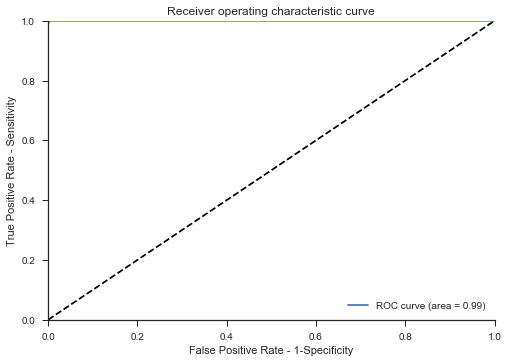

In [14]:
# check performance on training data
y_train_predicted = rfc.predict(X_train)
y_score = rfc.predict_proba(X_train)[:,1]
fpr, tpr, _ = roc_curve(y_train, y_score, pos_label=1)
auc = roc_auc_score(y_train, y_train_predicted)

# plot ROC curve
fig, ax = plt.subplots()
plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(float(auc)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate - 1-Specificity')
plt.ylabel('True Positive Rate - Sensitivity')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../Figures/auc_train.pdf')
plt.show()

## Check performance on testing data (= Belgian cohort)

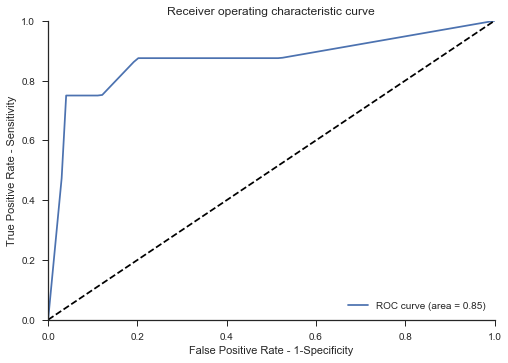

In [15]:
# make prediction, calculate predictions' probability and calculate auc value
y_test_predicted = rfc.predict(X_test)
y_score = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)
original_auc = roc_auc_score(y_test, y_test_predicted)

interval = np.linspace(0, 1, 100)
original_tpr = np.interp(interval, fpr, tpr)

# plot ROC curve
fig, ax = plt.subplots()
plt.plot(interval, original_tpr, label='ROC curve (area = {0:.2f})'.format(float(original_auc)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate - 1-Specificity')
plt.ylabel('True Positive Rate - Sensitivity')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../Figures/auc.pdf')
plt.show()

Calculate mean AUC/ROC (and confidence interval) for 1000 iterations with bootstrapped test samples

## Bootstrap AUC values

In [34]:
def bootstrap(test_sample, interval):
        
    # get features (X) and label (y) from test data
    X_test = test_sample[['TCR_sum', 'uniques']]
    y_test = [0 if x <= 10 else 1 for x in test_sample['CMV IgG'] ]

    # make prediction, calculate predictions' probability and calculate auc value
    y_test_predicted = rfc.predict(X_test)
    y_score = rfc.predict_proba(X_test)[:, 1]
    
    try:
        auc = roc_auc_score(y_test, y_test_predicted)
    except ValueError:
        print(test_sample)
        print()
        print(y_test)
        print()
        print(y_test_predicted)
        sys.exit()
    
    # keep fpr and tpr for mean roc plot
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=1)

    return auc, np.interp(interval, fpr, tpr)


iterations = 10000
aucs = []
tprs = []

classes = {'iteration': [], 'number_y': [], 'number_CMV': []}
for i in range(1, iterations+1):
        
    # select random samples with replacement
    test_sample = test.sample(axis=0, n=len(test), replace=True, random_state=i)
    
    y_test = [0 if x <= 10 else 1 for x in test_sample['CMV IgG'] ]
    
    if len(set(y_test)) != len(set(test_sample['CMV serostatus'])):
        classes['iteration'].append(i)
        classes['number_y'].append(len(set(y_test)))
        classes['number_CMV'].append(len(set(test_sample['CMV serostatus'])))
    
    if len(set(y_test)) == 1:
        classes['iteration'].append(i)
        classes['number_y'].append(len(set(y_test)))
        classes['number_CMV'].append(len(set(test_sample['CMV serostatus'])))
        
    auc, interpol = bootstrap(test_sample, interval)
    aucs.append(auc)
    tprs.append(interpol)
    
    if i % 100 == 0:
        print('Iteration: {}'.format(i))
        
print(classes)

Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Iteration: 3600
Iteration: 3700
Iteration: 3800
Iteration: 3900
Iteration: 4000
Iteration: 4100
Iteration: 4200
Iteration: 4300
Iteration: 4400
Iteration: 4500
Iteration: 4600
Iteration: 4700
Iteration: 4800
Iteration: 4900
Iteration: 5000
Iteration: 5100
Iteration: 5200
Iteration: 5300
Iteration: 5400
Iteration: 5500
Iteration: 5600
Iteration: 5700
Iteration: 5800
Iteration: 5900
Iteration: 6000
Iteration: 6100
Iteration: 6200
Iteration: 6300
I

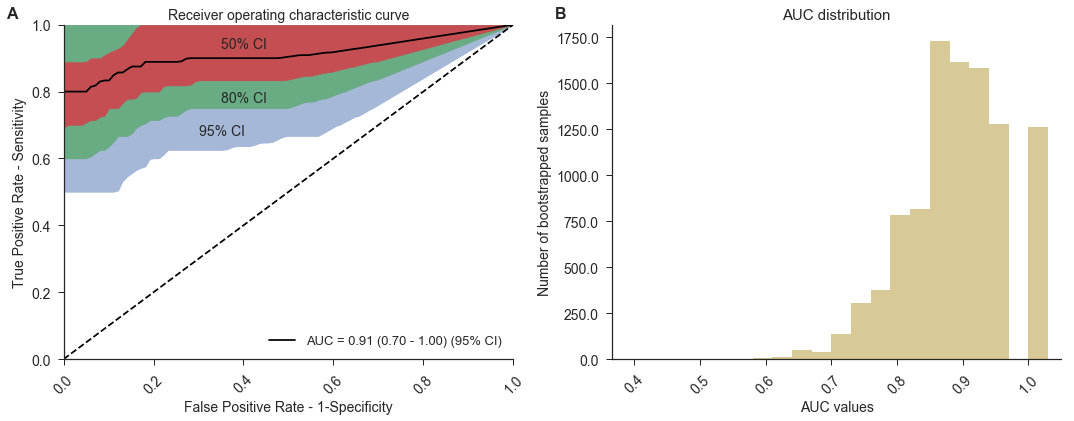

In [55]:
def auc_series(serie):
    
    ''' Calculate the AUC value of a series of tpr values over an interval of 100 values.
    To be applied to a dataframe containing tpr values as columns.'''
    
    interval = np.linspace(0, 1, 100)
    return sklearn.metrics.auc(interval, serie)


def ci_loc(perct, l=iterations):

    ''' Return an integer index value based on percentile value requested (perct) of a list l. 
    Eg: 5th percentile value of a list of length 40 => 2nd value in list: 1 [(0.05*40)-1]'''
    
    return int(perct*iterations)-1

# calculate mean auc and confidence interval
auc_mean = np.mean(aucs)

# CI column locations in df
loc_ci_25 = ci_loc(.025)
loc_ci_975 = ci_loc(.975)
loc_ci_100 = ci_loc(.100)
loc_ci_900 = ci_loc(.900)
loc_ci_250 = ci_loc(.250)
loc_ci_750 = ci_loc(.750)
loc_ci_500 = ci_loc(.500)

tpr_df = pd.DataFrame(tprs)
tpr_df['auc'] = tpr_df.apply(auc_series, axis=1)

# sort by auc values
tpr_df.sort_values(by='auc', inplace=True)

# sort each column separately
tpr_df = tpr_df.apply(lambda x: np.sort(x.values))

sklearn.metrics.auc(interval, tpr_df.iloc[loc_ci_975, :100])

# plot out auc values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(interval, 
         tpr_df.iloc[int(iterations/2)-1, :100], 
         color='k',
         label='AUC = {:.2f} ({:.2f} - {:.2f}) (95% CI)'.format(sklearn.metrics.auc(interval, tpr_df.iloc[loc_ci_500, :100]),
                                                         sklearn.metrics.auc(interval, tpr_df.iloc[loc_ci_25, :100]),
                                                         sklearn.metrics.auc(interval, tpr_df.iloc[loc_ci_975, :100])))
ax1.fill_between(interval, 
                 tpr_df.iloc[loc_ci_25, :100], 
                 tpr_df.iloc[loc_ci_975, :100],
                 alpha=0.5,
                 color=sns.color_palette()[0])
ax1.annotate('95% CI', xy=(.3, .67), fontsize=14)
ax1.fill_between(interval, 
                 tpr_df.iloc[loc_ci_100, :100], 
                 tpr_df.iloc[loc_ci_900, :100],
                 alpha=0.75,
                 color=sns.color_palette()[1])
ax1.annotate('80% CI', xy=(.35, .77), fontsize=14)
ax1.fill_between(interval, 
                 tpr_df.iloc[loc_ci_250, :100], 
                 tpr_df.iloc[loc_ci_750, :100],
                 alpha=1,
                 color=sns.color_palette()[2])
ax1.annotate('50% CI', xy=(.35, .93), fontsize=14)
ax1.annotate('A', 
            xy=(-0.1, 1.1), 
            xycoords='axes fraction', 
            textcoords='offset points',
            fontsize=16, 
            xytext=(0, -15), 
            weight='bold', 
            ha='right', 
            va='top')
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_title('Receiver operating characteristic curve', size=14)
ax1.set_xlabel('False Positive Rate - 1-Specificity', size=14)
ax1.set_xticklabels(labels=ax1.get_xticks(), rotation=45, size=14)
ax1.set_ylabel('True Positive Rate - Sensitivity', size=14)
ax1.set_yticklabels(labels=ax1.get_yticks(), rotation='horizontal', size=14)
ax1.legend(loc="lower right", fontsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

bins= [x/100 for x in range(40, 110, 3)]
sns.distplot(aucs, kde=False, ax=ax2, bins=bins, color=sns.color_palette()[4], hist_kws={"alpha": .75})
ax2.annotate('B', 
            xy=(-0.1, 1.1), 
            xycoords='axes fraction', 
            textcoords='offset points',
            fontsize=16, 
            xytext=(0, -15), 
            weight='bold', 
            ha='right', 
            va='top')
ax2.set_title('AUC distribution', size=15)
ax2.set_xlabel('AUC values', size=14)
ax2.set_xticklabels(labels=ax2.get_xticks(), rotation=45, size=14)
ax2.set_xlim(xmax=1.05)
ax2.set_ylabel('Number of bootstrapped samples', size=14)
ax2.set_yticklabels(labels=ax2.get_yticks(), rotation='horizontal', size=14)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

plt.tight_layout()

plt.savefig('../figures/median_roc_curve.png', dpi=600)
plt.show()